<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-data-and-parameters" data-toc-modified-id="Import-data-and-parameters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import data and parameters</a></span></li><li><span><a href="#System-initialization" data-toc-modified-id="System-initialization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>System initialization</a></span></li><li><span><a href="#Simulation" data-toc-modified-id="Simulation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Simulation</a></span><ul class="toc-item"><li><span><a href="#Scenario-parameters" data-toc-modified-id="Scenario-parameters-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Scenario parameters</a></span></li><li><span><a href="#Simulation-main" data-toc-modified-id="Simulation-main-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Simulation main</a></span></li><li><span><a href="#Price-evolution" data-toc-modified-id="Price-evolution-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Price evolution</a></span></li><li><span><a href="#Supply-and-demand-evolution" data-toc-modified-id="Supply-and-demand-evolution-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Supply and demand evolution</a></span></li></ul></li><li><span><a href="#Scenario-analysis" data-toc-modified-id="Scenario-analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Scenario analysis</a></span></li></ul></div>

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
idx = pd.IndexSlice
import random 
from scipy import stats

from mine_simulation_tools import *
from refinery import *
from scrap_supply_tools import *
from demand_tools import *
from price_formation import *

# Import data and parameters

In [7]:
## High level parameters
historical_prod=pd.read_excel('Data/Production data compile.xlsx', sheet_name='Selected', index_col=0)
historical_price=pd.read_excel('Data/Price data compile.xlsx', sheet_name='Price', index_col=0) # All prices 2017 constant

# Specific prod and mine data
historical_mining_prod=historical_prod.loc[:, 'Total mining production']
historical_lme_price=historical_price.loc[:, 'LME']
historical_tcrc=historical_price.loc[:, 'Annual TCRC']
historical_no2=historical_price.loc[:, 'No.2 ref']
historical_sp2=historical_lme_price-historical_no2


## Primary supply data and patameters
operating_mine_pool=pd.read_excel('Data/primary supply/Operating mine pool.xls', sheet_name='Sheet1', index_col=0)
open_parameter=pd.read_excel('Data/primary supply/Opening subsample parameter.xlsx', sheet_name='max5', index_col=0)
incentive_pool=pd.read_excel('Data/primary supply/Incentive mine pool.xls', sheet_name='Sheet1', index_col=0)
pri_hyper_param=pd.read_excel('Data/primary supply/Hyperparameters.xlsx', sheet_name='Sheet1', index_col=0)


## Refinery parameters
ref_hyper_param=pd.read_excel('Data/refined supply/Refinery hyperparameter.xlsx', sheet_name='Parameters', index_col=0)
conc_to_cathode_eff=ref_hyper_param.loc['conc to cathode eff', 'Value']
scrap_to_cathode_eff=ref_hyper_param.loc['scrap to cathode eff', 'Value']


## Semis demand parameters
gdp_growth_prediction_base=pd.read_excel('Data/semis demand/Demand prediction data.xlsx', sheet_name='GDP growth', index_col=0, usecols=np.arange(6))
volume_prediction_base=pd.read_excel('Data/semis demand/Demand prediction data.xlsx', sheet_name='All sectors', index_col=0, header=[0,1])
intensity_prediction=pd.read_excel('Data/semis demand/Intensity initial.xls', sheet_name='Sheet1', index_col=0, header=[0,1])
elas_sec_reg=pd.read_excel('Data/semis demand/Elasticity estimates.xlsx', sheet_name='S+R S intercept only', index_col=0)
sector_shape_matrix=pd.read_excel('Data/semis demand/Sector to shape matrix.xlsx', sheet_name='Sheet1', index_col=0)
calibration_1718=pd.read_excel('Data/semis demand/2017 and 2018 calibration.xlsx', sheet_name='Sheet1', index_col=0)

# Adjust demand in 2018 to scale it back to ICSG
intensity_prediction.loc[2017, :] = intensity_prediction.loc[2017, :]\
.mul(calibration_1718.loc[2017, 'ICSG refined usage']).div(calibration_1718.loc[2017, 'simulated refined usage'])
intensity_prediction.loc[2018, :] = intensity_prediction.loc[2018, :]\
.mul(calibration_1718.loc[2018, 'ICSG refined usage']).div(calibration_1718.loc[2018, 'simulated refined usage'])
demand_prediction=volume_prediction_base.loc[2015:, :].mul(intensity_prediction.fillna(0))


## Scrap supply parameters
use_sector_combined=pd.read_excel('Data/scrap supply/End use combined data.xlsx', sheet_name='Combined', index_col=0)
sector_to_product=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='sector to product', index_col=0)
product_to_waste=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='product to waste', index_col=0)
product_life_and_eff=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='product lifetime and efficiency', index_col=0)
product_to_cathode_alloy=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='product to copper or alloy', index_col=0)
recycle_efficiency=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='recycling efficiency', index_col=0)

# Home scrap ratio
home_scrap_ratio_file=pd.read_excel('Data/scrap supply/Home scrap ratio.xls', sheet_name='Sheet1', index_col=0)
home_scrap_ratio_series=home_scrap_ratio_file.loc[:, 'Calibrated ratio']
exchange_scrap_ratio_series=0.9-home_scrap_ratio_series

# Sector end use to product matrix 
use_product_history=pd.DataFrame(np.matmul(use_sector_combined, sector_to_product.transpose()), 
                                 index=use_sector_combined.index, columns=sector_to_product.index)
# Product to waste matrices
product_to_waste_collectable=product_to_waste.iloc[:, :-2]
product_to_waste_no_loss=product_to_waste_collectable.mul(1/product_to_waste_collectable.sum(axis=1), axis=0)

# Product lifetime parameters and frequencies
product_lifetime=product_life_and_eff.loc[:, 'Lifetime']
product_lifetime_df=lifetime_df(product_lifetime)
product_lifetime_freq_df=lifetime_freq_df(product_lifetime_df)

# Recycling and fabrication efficiencies
sort_eff=recycle_efficiency.iloc[:, 0]
collect_rate=recycle_efficiency.iloc[:, 1]
fab_eff=product_life_and_eff.loc[:, 'Fabrication efficiency']
new_scrap_gen=1/fab_eff-1
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
collect_rate_series=pd.DataFrame(np.array((list(collect_rate)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=collect_rate.index)

## Price formation parameters
price_formation_param=pd.read_excel('Data/price formation/Price formation.xlsx', sheet_name='Sheet1', index_col=0)
cathode_sd_elas=price_formation_param.loc['Cathode SD elasticity', 'Value']
conc_sd_elas=price_formation_param.loc['Concentrate SD elasticity', 'Value']
cathode_sp2_elas=price_formation_param.loc['SP2 cathode elasticity', 'Value']
sp2_sd_elas=price_formation_param.loc['SP2 SD elasticity', 'Value']

# System initialization

In [8]:
# Initialize simulation time
history_start_time='19600101'
simulation_start_time='20180101'
simulation_end_time='20400101'
simulation_time=pd.date_range(simulation_start_time, simulation_end_time, freq='AS')
history_time=pd.date_range(history_start_time, simulation_start_time, freq='AS')

# Cathode price
cathode_price_series=pd.Series(0, index=history_time)
cathode_price_series.loc[:'20180101']=historical_lme_price.values

# TCRC
tcrc_series=pd.Series(0, index=history_time)
tcrc_series.loc[:'20180101']=historical_tcrc.values

# No.2 scrap spread
sp2_series=pd.Series(0, index=history_time)
sp2_series.loc[:'20180101']=historical_sp2.values

# Initialize mining stats
mine_life_stats_panel_operating=mine_life_stats_panel_init(simulation_time, operating_mine_pool)
mine_pool_new_last=pd.DataFrame()
mine_life_stats_panel_new_last=pd.DataFrame()
total_mining_prod=pd.Series(0, index=simulation_time)

# Initilize sxew ids
sxew_id_operating_bool=operating_mine_pool.loc[:, 'Payable percent (%)']==100
sxew_id_operating=[i for i in sxew_id_operating_bool.index if sxew_id_operating_bool.loc[i]]
sxew_id_new_bool=incentive_pool.loc[:, 'Payable percent (%)']==100
sxew_id_new=[i for i in sxew_id_new_bool.index if sxew_id_new_bool.loc[i]]
sxew_new=pd.Series(0, index=simulation_time)
sxew_all=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
sxew_all.loc['20170101']=historical_prod.loc[2017, 'SX-EW production']

# Initialize refinery stats
ref_stats=ref_stats_init(simulation_time, ref_hyper_param)

# Initialize concentrate prod, add 2017
conc_prod_series=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
conc_prod_series.loc['20170101']=historical_prod.loc[2017, 'Concentrate production']

# Initialize refined supply and demand
ref_prod_series=pd.Series(0, index=simulation_time)
ref_demand_series=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
ref_demand_series.loc['20170101']=historical_prod.loc[2017, 'Refined usage']

# Initialize end use by product stats
use_product_future=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=use_product_history.columns)
use_product_all_life=pd.concat([use_product_history, use_product_future])

# Initialize old scrap history
product_eol_history=product_reach_eol(use_product_history, product_lifetime_freq_df)
waste_from_old_history=pd.DataFrame(np.matmul(product_eol_history, product_to_waste_collectable), 
                                     index=product_eol_history.index, 
                                     columns=product_to_waste_collectable.columns).mul(sort_eff).mul(collect_rate)

waste_from_old_future=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=product_to_waste_collectable.columns)
waste_from_old_all_life=pd.concat([waste_from_old_history, waste_from_old_future])

# Initialize old scrap history
waste_from_new_history=pd.DataFrame(0, index=waste_from_old_history.index, columns=product_to_waste_collectable.columns)
for year_i in waste_from_new_history.index:
    home_scrap_ratio=home_scrap_ratio_series.loc[year_i]
    exchange_scrap_ratio=exchange_scrap_ratio_series.loc[year_i]
    waste_from_new_year_i=\
    simulate_new_scrap_one_year(year_i, use_product_history, new_scrap_gen, product_to_waste_no_loss, sort_eff, 
                                home_scrap_ratio, exchange_scrap_ratio)
    waste_from_new_history.loc[year_i]=waste_from_new_year_i.values

waste_from_new_future=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=product_to_waste_collectable.columns)
waste_from_new_all_life=pd.concat([waste_from_new_history, waste_from_new_future])

waste_all_life=waste_from_old_all_life+waste_from_new_all_life

# Initialize scrap demand
direct_melt_scrap_demand=use_product_all_life.mul(product_to_cathode_alloy.loc[:, 'Alloyed']).sum(axis=1)
refined_scrap_demand=historical_prod.loc[:, 'Secondary refining production'].div(scrap_to_cathode_eff)
total_scrap_demand_all_life=pd.DataFrame({'Direct melt scrap': direct_melt_scrap_demand, 
                                          'Refined scrap': refined_scrap_demand})


# Simulation

Some tuning parameters
1. **sec_coef**, describes to what extent secondary refinery capacity growth follows scrap supply
2. **open_parameter**, how many mines to assess for opening possibility
3. **sp2_sd_elas**, The elasticity of SP2 to scrap S-D. This is not estimated through regression, value just assigned

## Scenario parameters

Scenario baseline: 
1. Closing method is max, closing year is ten

In [9]:
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sec_coef=0
sp2_sd_elas=0.0845
close_price_method='max'
close_years_back=10

Scenario 22: 
1. Sorting efficiency increases by 10% in 2019 only, and recovers to original level
2. Closing method is max, closing year is ten

In [25]:
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sort_eff_series.loc[2019, :]+=0.1
sec_coef=0
sp2_sd_elas=0.0845
close_price_method='max'
close_years_back=10

Scenario 23: 
1. Sorting efficiency increases by 5% in 2019 only, and recovers to original level
2. Closing method is max, closing year is ten

In [48]:
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sort_eff_series.loc[2019, :]+=0.05
sec_coef=0
sp2_sd_elas=0.0845
close_price_method='max'
close_years_back=10

Scenario 24: 
1. Sorting efficiency increases by 1% in 2019 only, and recovers to original level
2. Closing method is max, closing year is ten

In [68]:
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sort_eff_series.loc[2019, :]+=0.01
sec_coef=0
sp2_sd_elas=0.0845
close_price_method='max'
close_years_back=10

Scenario 4: 
1. Sorting efficiency increases by 0.1% in 2019 only, and recovers to original level

In [99]:
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sort_eff_series.loc[2019, :]+=0.001
sec_coef=0

Scenario 6: 
1. Sorting efficiency increases by 0.1% 2019 to 2040

In [145]:
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sort_eff_series.loc[2019:, :]+=0.001
sec_coef=0

Scenario 7: 
1. Sorting efficiency increases by 0.01% 2019 to 2040

In [193]:
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sort_eff_series.loc[2019:, :]+=0.0001
sec_coef=0

Scenario 9: 
1. Sorting efficiency increases by 0.01% in 2019 only

In [218]:
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sort_eff_series.loc[2019, :]+=0.0001
sec_coef=0

Scenario 10: 
1. Sorting efficiency increases by 1% in 2019 only

In [243]:
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sort_eff_series.loc[2019, :]+=0.01
sec_coef=0

Scenario 14: 
1. Sorting efficiency increases by 0.7% in 2019 only

In [276]:
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sort_eff_series.loc[2019, :]+=0.007
sec_coef=0

Scenario 16: 
1. Sorting efficiency increases by 0.5% in 2019 only

In [305]:
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sort_eff_series.loc[2019, :]+=0.005
sec_coef=0

Scenario baseline high:
1. SP2 SD elasticity is twice the original

In [326]:
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sec_coef=0
sp2_sd_elas=0.0845*2

Scenario low elas, 18
1. SP2 SD elasticity is twice of original
2. Sorting efficiency increases by 0.001% in 2019

In [346]:
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sort_eff_series.loc[2019, :]+=0.00001
sec_coef=0
sp2_sd_elas=0.0845*2

Scenario 19:
2. Sorting efficiency increases by 10% in 2019

In [357]:
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sort_eff_series.loc[2019, :]+=0.1
sec_coef=0
sp2_sd_elas=0.0845

Scenario 21:
1. All sorting efficiency reaches 100% in 2019

In [374]:
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sort_eff_series.loc[2019, :]=1
sec_coef=0
sp2_sd_elas=0.0845

## Simulation main

In [10]:
for year_i in np.arange(2018, 2041):
    
    print(year_i)
    t=pd.datetime(year_i, 1, 1)
    t_lag_1=pd.datetime(year_i-1, 1, 1)
    t_lag_2=pd.datetime(year_i-2, 1, 1)
    
    #### Scenario parameters ####
    sort_eff=sort_eff_series.loc[year_i]
    
    #### Price formation ####
    if year_i > 2018:        
        ### Cathode price ###
        cathode_bal_l1=ref_prod_series.loc[t_lag_1]-ref_demand_series.loc[t_lag_1]
        cathode_price_series.loc[t]=cathode_price_predict(cathode_price_series.loc[t_lag_1], 
                                                          cathode_balance=cathode_bal_l1, cathode_sd_elas=cathode_sd_elas)

        ### TCRC ###
        conc_bal_l1=conc_prod_series.loc[t_lag_1]-ref_stats.loc[t_lag_1, 'Primary production']/conc_to_cathode_eff
        tcrc_series.loc[t]=tcrc_predict(tcrc_series.loc[t_lag_1], 
                                        conc_balance=conc_bal_l1, conc_sd_elas=conc_sd_elas)
        
        ### SP2 ###
        scrap_bal_l1=waste_all_life.sum(axis=1).loc[year_i-1]-total_scrap_demand_all_life.sum(axis=1).loc[year_i-1]
        cathode_price_diff=cathode_price_series.loc[t]-cathode_price_series.loc[t_lag_1]
        sp2_series.loc[t]=sp2_predict(sp2_series.loc[t_lag_1], 
                                      scrap_balance=scrap_bal_l1, scrap_sd_elas=sp2_sd_elas, 
                                      cathode_diff=cathode_price_diff, cathode_sp2_elas=cathode_sp2_elas)
                
    # TCRC to cents per pound
    tcrc_cpp_series = tcrc_series.copy().div(22.0462)

 
    #### Production of operating mine ####
    for mine_id in operating_mine_pool.index:
        mine_data = operating_mine_pool.loc[mine_id]
        mine_life_stats = simulate_mine_life_stats_panel(simulation_time, year_i, 2018, 
                                                         mine_life_stats_panel_operating, mine_data, 
                                                         cathode_price_series, tcrc_cpp_series, pri_hyper_param,
                                                         close_price_method, close_years_back)
        mine_life_stats_panel_operating.loc[:, idx[mine_id, :]]=mine_life_stats.loc[simulation_time, :].values

    # Total production statistics
    prod_operating=mine_life_stats_panel_operating.loc[:, idx[:, 'Recovered metal production (kt)']].sum(axis=1)
    sxew_operating=mine_life_stats_panel_operating.loc[:, idx[sxew_id_operating, 'Recovered metal production (kt)']].sum(axis=1)
    conc_operating=prod_operating-sxew_operating
    
    
    #### Production of new mines ####
    if year_i > 2018:
        # Read subsample size parameter and generate new incentive pool for year_i
        subsample_size=open_parameter.loc[year_i, 'Subsample size']
        mine_pool_new_year_i=new_mine_data(year_i, simulation_end_time, incentive_pool, cathode_price_series, 
                                           pri_hyper_param, subsample_size, 0.15,
                                           close_price_method, close_years_back)
        print('New mines opening this year: ', mine_pool_new_year_i.shape[0])
      
        # Initialize mine life panel data for incentive pool year_i
        mine_life_stats_panel_new_year_i=mine_life_stats_panel_init(simulation_time, mine_pool_new_year_i)
      
        # Append new incentive pool at year_i
        mine_pool_new=pd.concat([mine_pool_new_last, mine_pool_new_year_i])
        mine_life_stats_panel_new=pd.concat([mine_life_stats_panel_new_last, mine_life_stats_panel_new_year_i], axis=1)
        
        for mine_id in mine_pool_new.index:
            mine_data = mine_pool_new.loc[mine_id]
            mine_life_stats = simulate_mine_life_stats_panel(simulation_time, year_i, mine_data.loc['Initial year'], 
                                                             mine_life_stats_panel_new, mine_data, 
                                                             cathode_price_series, tcrc_cpp_series, pri_hyper_param, 
                                                             close_price_method, close_years_back)
            mine_life_stats_panel_new.loc[:, idx[mine_id, :]]=mine_life_stats.loc[simulation_time, :].values
        
        
        # Total production statistics
        prod_new=mine_life_stats_panel_new.loc[:, idx[:, 'Recovered metal production (kt)']].sum(axis=1)
        sxew_new=mine_life_stats_panel_new.loc[:, idx[sxew_id_new, 'Recovered metal production (kt)']].sum(axis=1)
        conc_new=prod_new-sxew_new
        
        # Update incentive pool info
        mine_pool_new_last=mine_pool_new.copy()
        mine_life_stats_panel_new_last=mine_life_stats_panel_new.copy()

        
    #### Update total mining production ####
    if year_i == 2018:
        conc_new=pd.Series(0, index=simulation_time)
        prod_new=pd.Series(0, index=simulation_time)
        
    conc_prod_series.loc[t]=conc_operating.loc[t]+conc_new.loc[t]
    sxew_all.loc[t]=sxew_operating.loc[t]+sxew_new.loc[t]
    print('Total mining production: ', prod_operating.loc[t]+prod_new.loc[t])
    
    
    #### Demand for refined copper ####
    if year_i == 2018:
        pass
    else:
        intensity_next=intensity_prediction_one_year(year_i, cathode_price_series, gdp_growth_prediction_base, 
                                                     intensity_prediction.loc[year_i-1, :], volume_prediction_base, 
                                                     elas_sec_reg, method='sec and reg')
        intensity_prediction.loc[year_i, :]=intensity_next.values
        demand_prediction.loc[year_i, :]=intensity_prediction.loc[year_i, :].mul(volume_prediction_base.loc[year_i, :]).values
    
    # Demand by shape and refined copper demand
    demand_by_sector=demand_prediction.groupby(level=0, axis=1).sum()
    demand_by_shape=pd.DataFrame(np.matmul(demand_by_sector, sector_shape_matrix.transpose()), 
                                 index=demand_by_sector.index, columns=sector_shape_matrix.index)
    ref_demand_series.loc[t]=demand_by_shape.loc[year_i, 'Copper']
    
    
    #### Production of refineries ####
    if year_i == 2018:
        pass
    else:
        ref_stats_next=simulate_refinery_production_oneyear(year_i, tcrc_series, sp2_series, 
                                                            ref_demand_series, waste_all_life.sum(axis=1),
                                                            ref_stats, ref_hyper_param, 
                                                            sec_coef=sec_coef, growth_lag=1)
        ref_stats.loc[t, :]=ref_stats_next
    
    total_ref_prod=ref_stats.loc[t, 'Primary production']+ref_stats.loc[t, 'Secondary production']+sxew_all.loc[t]
    ref_prod_series.loc[t]=total_ref_prod

    
    #### Generation of old scrap ####
    if year_i > 2018:
        # Calculate end use by sector and by product
        use_sector_year_i=demand_prediction.groupby(level=0, axis=1).sum()\
                          .loc[:, list(sector_to_product.columns)].loc[year_i, :]
        use_product_year_i=pd.Series(np.matmul(use_sector_year_i, sector_to_product.transpose()), 
                                     index=sector_to_product.index)
        use_product_all_life.loc[year_i]=use_product_year_i.values
        
        # Product reaching end of life and waste collected
        product_eol_year_i=product_reach_eol_oneyear(year_i, use_product_all_life, product_lifetime_freq_df)
        waste_collected_year_i=waste_collected_oneyear(product_eol_year_i, product_to_waste_collectable, sort_eff, collect_rate)
        waste_from_old_future.loc[year_i]=waste_collected_year_i

        
    #### Generation of new scrap ####
    if year_i > 2018:
        home_scrap_ratio=home_scrap_ratio_series.loc[year_i]
        exchange_scrap_ratio=exchange_scrap_ratio_series.loc[year_i]
        waste_from_new_year_i=\
        simulate_new_scrap_one_year(year_i, use_product_all_life, new_scrap_gen, product_to_waste_no_loss, sort_eff,
                                    home_scrap_ratio, exchange_scrap_ratio)
        waste_from_new_future.loc[year_i]=waste_from_new_year_i
    
        # All scrap
        waste_all_life.loc[year_i]=waste_from_new_year_i+waste_collected_year_i
    
    print('Total scrap supply: ', waste_all_life.sum(axis=1).loc[year_i])
    
    
    #### Demand of scrap
    direct_melt_scrap_demand_year_i=use_product_all_life.mul(product_to_cathode_alloy.loc[:, 'Alloyed']).sum(axis=1).loc[year_i]
    refined_scrap_demand_year_i=ref_stats.loc[t, 'Secondary production']/scrap_to_cathode_eff
    total_scrap_demand_all_life.loc[year_i, 'Direct melt scrap']=direct_melt_scrap_demand_year_i
    total_scrap_demand_all_life.loc[year_i, 'Refined scrap']=refined_scrap_demand_year_i
    

2018
Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019


KeyError: 'the label [2016-01-01 00:00:00] is not in the [index]'

## Price evolution

In [16]:
trailing_years

NameError: name 'trailing_years' is not defined

In [20]:
tcrc_series.rolling(10).mean().loc[pd.datetime(2016,1,1)]

433.573759610077

<IPython.core.display.Javascript object>


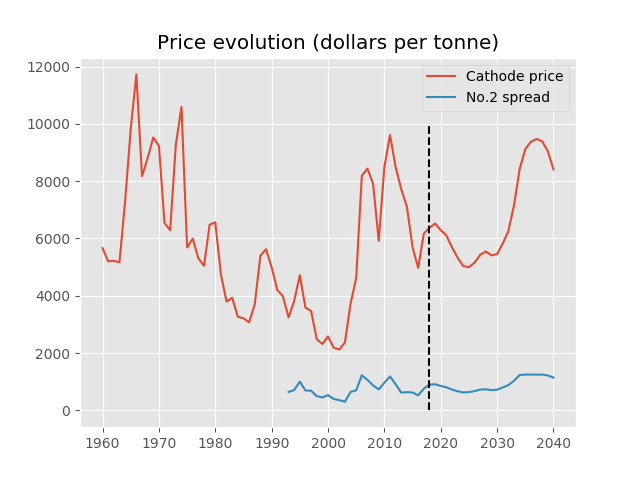

In [16]:
%matplotlib notebook
plt.style.use('ggplot')
plt.plot(cathode_price_series, label='Cathode price')
plt.plot(sp2_series, label='No.2 spread')
plt.plot([pd.datetime(2018,1,1), pd.datetime(2018,1,1)], [0, 10000], 'k--')

plt.legend()
plt.title('Price evolution (dollars per tonne)')
plt.show()


In [71]:
# No.2 spread and cathode price correlation
print(sp2_series.diff().loc[:'20180101'].corr(cathode_price_series.diff().loc[:'20180101']))
print(sp2_series.diff().loc['20190101':].corr(cathode_price_series.diff().loc['20190101':]))

0.8490678763866732
0.9805176665319598


<IPython.core.display.Javascript object>


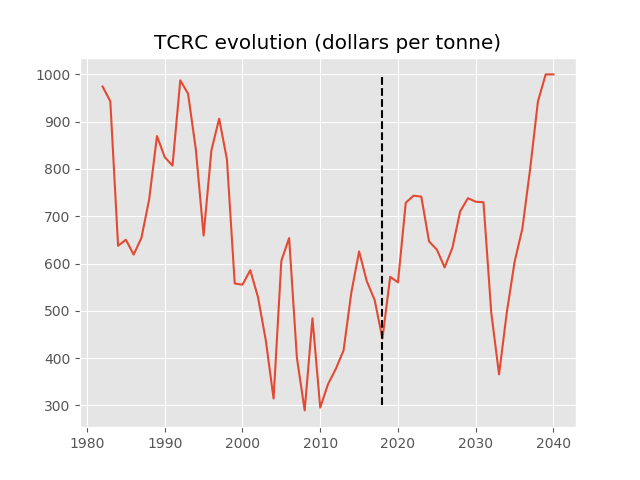

In [17]:
%matplotlib notebook
plt.style.use('ggplot')
plt.plot(tcrc_series)
plt.plot([pd.datetime(2018,1,1), pd.datetime(2018,1,1)], [300, 1000], 'k--')
plt.title('TCRC evolution (dollars per tonne)')
plt.show()


In [18]:
prices_simulated=pd.DataFrame({'Cathode': cathode_price_series, 'No.2 spread': sp2_series, 'TCRC': tcrc_series})
prices_simulated.to_excel('Data/scenario results/simulated price baseline max10.xls')

## Supply and demand evolution

In [19]:
mining_prod_df_future=pd.concat([conc_operating+conc_new, sxew_operating+sxew_new], axis=1)
mining_prod_df_future.columns=['Concentrate production', 'SX-EW production']
mining_prod_df_history=historical_prod.loc[:, ['Concentrate production', 'SX-EW production']].iloc[:-1, :]
mining_prod_df_history.index=pd.date_range('19500101', '20170101', freq='AS')
mining_prod_df_all=pd.concat([mining_prod_df_history, mining_prod_df_future])

conc_demand_history=pd.Series(historical_prod.loc[1950:, 'Primary refining production'].values, 
                              index=pd.date_range('19500101', '20180101', freq='AS')).div(0.99)
conc_demand_all=pd.concat([conc_demand_history.loc[:'20170101'], ref_stats.loc[:, 'Primary production'].div(0.99)])
conc_demand_all.name='Concentrate demand'


ref_prod_df_history=\
historical_prod.loc[:, ['Primary refining production', 'Secondary refining production', 'SX-EW production']].iloc[10:-1, :]
ref_prod_df_history.index=pd.date_range('19600101', '20170101', freq='AS')
ref_prod_df_future=pd.concat([ref_stats.loc[:, ['Primary production', 'Secondary production']], sxew_all.iloc[1:]], axis=1)
ref_prod_df_future.columns=ref_prod_df_history.columns
ref_prod_df_all=pd.concat([ref_prod_df_history, ref_prod_df_future])

ref_demand_history=pd.Series(historical_prod.loc[1950:, 'Refined usage'].values, 
                              index=pd.date_range('19500101', '20180101', freq='AS'))
ref_demand_all=pd.concat([ref_demand_history, ref_demand_series.loc['20190101':]])
ref_demand_all.name='Refined demand'


scrap_supply=waste_all_life.loc[1950:].sum(axis=1)
scrap_supply.index=pd.date_range('19500101', '20400101', freq='AS')
scrap_supply.name='Scrap production'

scrap_demand=total_scrap_demand_all_life.loc[1950:, :]
scrap_demand.index=pd.date_range('19500101', '20400101', freq='AS')

In [20]:
sd_simulated=pd.concat([mining_prod_df_all, conc_demand_all, ref_prod_df_all, ref_demand_all, scrap_supply, scrap_demand],axis=1)
sd_simulated.to_excel('Data/scenario results/simulated supply and demand baseline max10.xls')

<IPython.core.display.Javascript object>


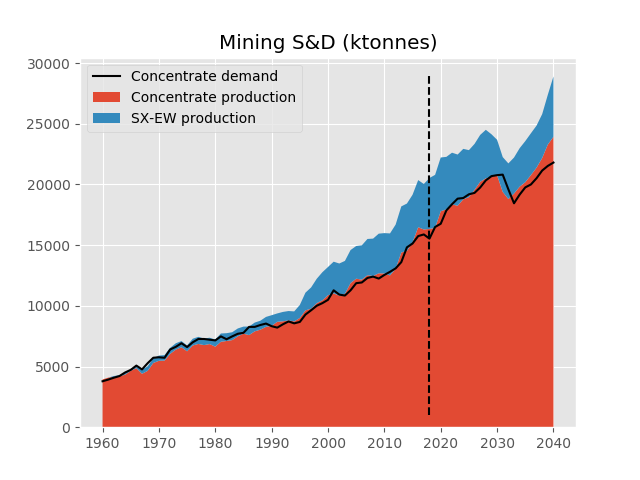

In [21]:
%matplotlib notebook
plt.stackplot(mining_prod_df_all.loc['19600101':, :].index, mining_prod_df_all.loc['19600101':, :].transpose(), 
              labels=mining_prod_df_all.columns)
plt.plot(conc_demand_all, 'k', label='Concentrate demand')

plt.plot([pd.datetime(2018,1,1), pd.datetime(2018,1,1)], [1000, 29000], 'k--')
plt.legend(loc=2)
plt.title('Mining S&D (ktonnes)')
plt.show()

<IPython.core.display.Javascript object>


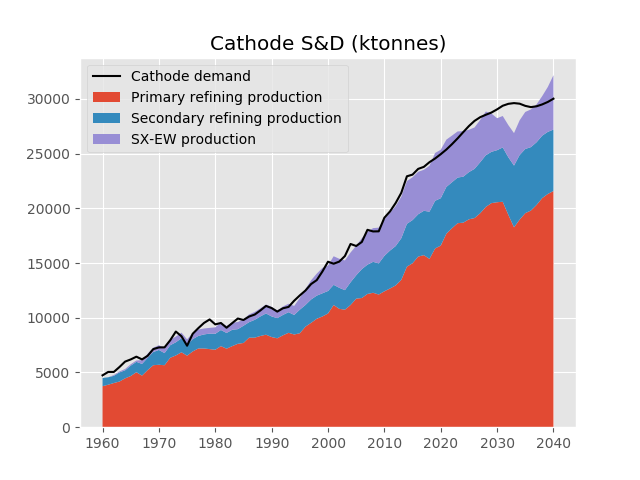

In [22]:
%matplotlib notebook
plt.stackplot(ref_prod_df_all.index, ref_prod_df_all.transpose(), 
              labels=ref_prod_df_all.columns)
plt.plot(ref_demand_all, 'k', label='Cathode demand')

# plt.plot([pd.datetime(2018,1,1), pd.datetime(2018,1,1)], [1000, 34000], 'k--')
plt.legend(loc=2)
plt.title('Cathode S&D (ktonnes)')
plt.show()

<IPython.core.display.Javascript object>


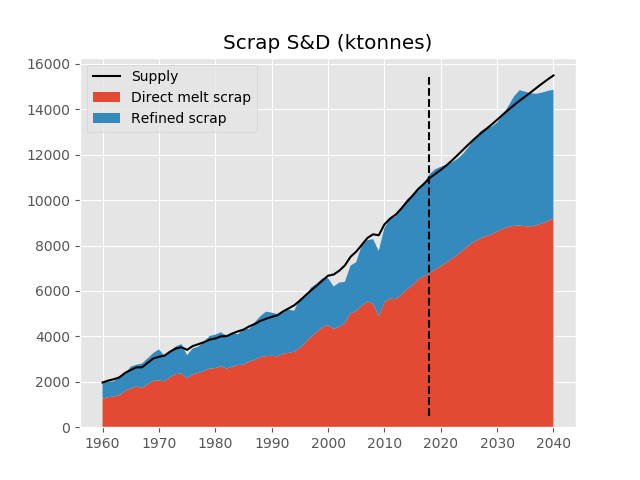

In [23]:
%matplotlib notebook
plt.plot(scrap_supply.loc['19600101':], 'k', label='Supply')
plt.stackplot(scrap_demand.loc['19600101':, :].index, scrap_demand.loc['19600101':, :].transpose(), 
              labels=scrap_demand.columns)

plt.plot([pd.datetime(2018,1,1), pd.datetime(2018,1,1)], [500, 15500], 'k--')
plt.title('Scrap S&D (ktonnes)')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


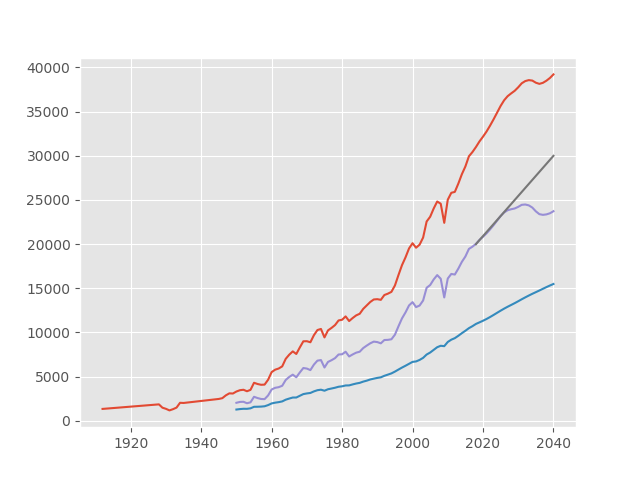

In [49]:
%matplotlib notebook
plt.plot(use_product_all_life.sum(axis=1))
plt.plot(pd.Series(scrap_supply.values, index=np.arange(1950, 2041)))
plt.plot(use_product_all_life.sum(axis=1)-pd.Series(scrap_supply.values, index=np.arange(1950, 2041)))
plt.plot([2018,2040], [20000,30000])

plt.show()

# Scenario analysis

In [386]:
sd_baseline=pd.read_excel('Data/scenario results/simulated supply and demand baseline.xls', sheet_name='Sheet1', index_col=0)
scrap_supply_baseline=sd_baseline.loc['19600101':, 'Scrap production']
mining_supply_baseline=sd_baseline.loc['19600101':, ['Concentrate production', 'SX-EW production']].sum(axis=1)

In [ ]:
sd_baseline_max10=pd.read_excel('Data/scenario results/simulated supply and demand baseline max10.xls', sheet_name='Sheet1', index_col=0)
scrap_supply_baseline_max10=sd_baseline_max10.loc['19600101':, 'Scrap production']
mining_supply_baseline_max10=sd_baseline_max10.loc['19600101':, ['Concentrate production', 'SX-EW production']].sum(axis=1)

NameError: name 'pd' is not defined

In [166]:
sd_sc1=pd.read_excel('Data/scenario results/simulated supply and demand sc1.xls', sheet_name='Sheet1', index_col=0)
scrap_supply_sc1=sd_sc1.loc['19600101':, 'Scrap production']
mining_supply_sc1=sd_sc1.loc['19600101':, ['Concentrate production', 'SX-EW production']].sum(axis=1)

shock_sc1_perm=scrap_supply_sc1-scrap_supply_baseline
mining_response_sc1=mining_supply_sc1-mining_supply_baseline
displacement_sc1=mining_response_sc1.cumsum().div(shock_sc1_perm.cumsum()).mul(-1)

In [178]:
sd_sc4=pd.read_excel('Data/scenario results/simulated supply and demand sc4.xls', sheet_name='Sheet1', index_col=0)
scrap_supply_sc4=sd_sc4.loc['19600101':, 'Scrap production']
mining_supply_sc4=sd_sc4.loc['19600101':, ['Concentrate production', 'SX-EW production']].sum(axis=1)

shock_sc4_perm=scrap_supply_sc4-scrap_supply_baseline
mining_response_sc4=mining_supply_sc4-mining_supply_baseline
displacement_sc4=mining_response_sc4.cumsum().div(shock_sc4_perm.cumsum()).mul(-1)

In [168]:
sd_sc6=pd.read_excel('Data/scenario results/simulated supply and demand sc6.xls', sheet_name='Sheet1', index_col=0)
scrap_supply_sc6=sd_sc6.loc['19600101':, 'Scrap production']
mining_supply_sc6=sd_sc6.loc['19600101':, ['Concentrate production', 'SX-EW production']].sum(axis=1)

shock_sc6_perm=scrap_supply_sc6-scrap_supply_baseline
mining_response_sc6=mining_supply_sc6-mining_supply_baseline
displacement_sc6=mining_response_sc6.cumsum().div(shock_sc6_perm.cumsum()).mul(-1)

In [208]:
sd_sc7=pd.read_excel('Data/scenario results/simulated supply and demand sc7.xls', sheet_name='Sheet1', index_col=0)
scrap_supply_sc7=sd_sc7.loc['19600101':, 'Scrap production']
mining_supply_sc7=sd_sc7.loc['19600101':, ['Concentrate production', 'SX-EW production']].sum(axis=1)

shock_sc7_perm=scrap_supply_sc7-scrap_supply_baseline
mining_response_sc7=mining_supply_sc7-mining_supply_baseline
displacement_sc7=mining_response_sc7.cumsum().div(shock_sc7_perm.cumsum()).mul(-1)

In [233]:
sd_sc9=pd.read_excel('Data/scenario results/simulated supply and demand sc9.xls', sheet_name='Sheet1', index_col=0)
scrap_supply_sc9=sd_sc9.loc['19600101':, 'Scrap production']
mining_supply_sc9=sd_sc9.loc['19600101':, ['Concentrate production', 'SX-EW production']].sum(axis=1)

shock_sc9_perm=scrap_supply_sc9-scrap_supply_baseline
mining_response_sc9=mining_supply_sc9-mining_supply_baseline
displacement_sc9=mining_response_sc9.cumsum().div(shock_sc9_perm.cumsum()).mul(-1)

In [257]:
sd_sc10=pd.read_excel('Data/scenario results/simulated supply and demand sc10.xls', sheet_name='Sheet1', index_col=0)
scrap_supply_sc10=sd_sc10.loc['19600101':, 'Scrap production']
mining_supply_sc10=sd_sc10.loc['19600101':, ['Concentrate production', 'SX-EW production']].sum(axis=1)

shock_sc10_perm=scrap_supply_sc10-scrap_supply_baseline
mining_response_sc10=mining_supply_sc10-mining_supply_baseline
displacement_sc10=mining_response_sc10.cumsum().div(shock_sc10_perm.cumsum()).mul(-1)

In [293]:
sd_sc14=pd.read_excel('Data/scenario results/simulated supply and demand sc14.xls', sheet_name='Sheet1', index_col=0)
scrap_supply_sc14=sd_sc14.loc['19600101':, 'Scrap production']
mining_supply_sc14=sd_sc14.loc['19600101':, ['Concentrate production', 'SX-EW production']].sum(axis=1)

shock_sc14_perm=scrap_supply_sc14-scrap_supply_baseline
mining_response_sc14=mining_supply_sc14-mining_supply_baseline
displacement_sc14=mining_response_sc14.cumsum().div(shock_sc14_perm.cumsum()).mul(-1)

In [318]:
sd_sc16=pd.read_excel('Data/scenario results/simulated supply and demand sc16.xls', sheet_name='Sheet1', index_col=0)
scrap_supply_sc16=sd_sc16.loc['19600101':, 'Scrap production']
mining_supply_sc16=sd_sc16.loc['19600101':, ['Concentrate production', 'SX-EW production']].sum(axis=1)

shock_sc16_perm=scrap_supply_sc16-scrap_supply_baseline
mining_response_sc16=mining_supply_sc16-mining_supply_baseline
displacement_sc16=mining_response_sc16.cumsum().div(shock_sc16_perm.cumsum()).mul(-1)

In [368]:
sd_sc19=pd.read_excel('Data/scenario results/simulated supply and demand sc19.xls', sheet_name='Sheet1', index_col=0)
scrap_supply_sc19=sd_sc19.loc['19600101':, 'Scrap production']
mining_supply_sc19=sd_sc19.loc['19600101':, ['Concentrate production', 'SX-EW production']].sum(axis=1)

shock_sc19_perm=scrap_supply_sc19-scrap_supply_baseline
mining_response_sc19=mining_supply_sc19-mining_supply_baseline
displacement_sc19=mining_response_sc19.cumsum().div(shock_sc19_perm.cumsum()).mul(-1)

In [387]:
sd_sc21=pd.read_excel('Data/scenario results/simulated supply and demand sc21.xls', sheet_name='Sheet1', index_col=0)
scrap_supply_sc21=sd_sc21.loc['19600101':, 'Scrap production']
mining_supply_sc21=sd_sc21.loc['19600101':, ['Concentrate production', 'SX-EW production']].sum(axis=1)

shock_sc21_perm=scrap_supply_sc21-scrap_supply_baseline
mining_response_sc21=mining_supply_sc21-mining_supply_baseline
displacement_sc21=mining_response_sc21.cumsum().div(shock_sc21_perm.cumsum()).mul(-1)

In [42]:
sd_sc22=pd.read_excel('Data/scenario results/simulated supply and demand sc22.xls', sheet_name='Sheet1', index_col=0)
scrap_supply_sc22=sd_sc22.loc['19600101':, 'Scrap production']
mining_supply_sc22=sd_sc22.loc['19600101':, ['Concentrate production', 'SX-EW production']].sum(axis=1)

shock_sc22_perm=scrap_supply_sc22-scrap_supply_baseline_max10
mining_response_sc22=mining_supply_sc22-mining_supply_baseline_max10
displacement_sc22=mining_response_sc22.cumsum().div(shock_sc22_perm.cumsum()).mul(-1)

In [61]:
sd_sc23=pd.read_excel('Data/scenario results/simulated supply and demand sc23.xls', sheet_name='Sheet1', index_col=0)
scrap_supply_sc23=sd_sc23.loc['19600101':, 'Scrap production']
mining_supply_sc23=sd_sc23.loc['19600101':, ['Concentrate production', 'SX-EW production']].sum(axis=1)

shock_sc23_perm=scrap_supply_sc23-scrap_supply_baseline_max10
mining_response_sc23=mining_supply_sc23-mining_supply_baseline_max10
displacement_sc23=mining_response_sc23.cumsum().div(shock_sc23_perm.cumsum()).mul(-1)

In [81]:
sd_sc24=pd.read_excel('Data/scenario results/simulated supply and demand sc24.xls', sheet_name='Sheet1', index_col=0)
scrap_supply_sc24=sd_sc24.loc['19600101':, 'Scrap production']
mining_supply_sc24=sd_sc24.loc['19600101':, ['Concentrate production', 'SX-EW production']].sum(axis=1)

shock_sc24_perm=scrap_supply_sc24-scrap_supply_baseline_max10
mining_response_sc24=mining_supply_sc24-mining_supply_baseline_max10
displacement_sc24=mining_response_sc24.cumsum().div(shock_sc24_perm.cumsum()).mul(-1)

<IPython.core.display.Javascript object>


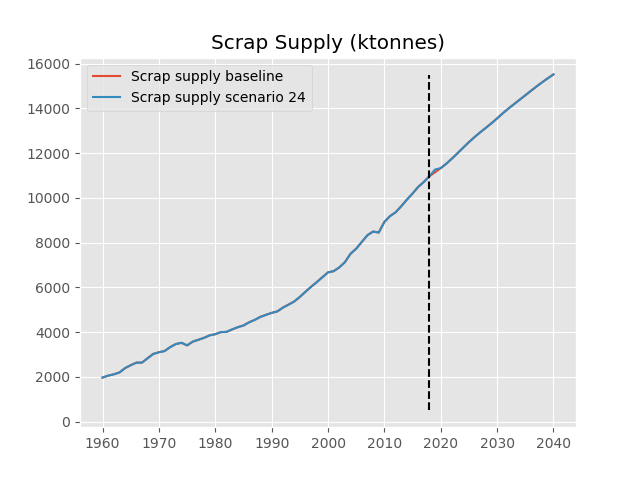

In [83]:
%matplotlib notebook
plt.plot(scrap_supply_baseline_max10, label='Scrap supply baseline')
plt.plot(scrap_supply_sc24, label='Scrap supply scenario 24')

plt.plot([pd.datetime(2018,1,1), pd.datetime(2018,1,1)], [500, 15500], 'k--')
plt.title('Scrap Supply (ktonnes)')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


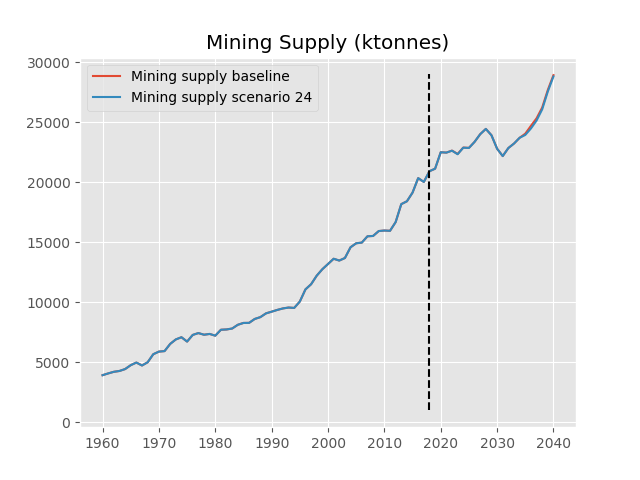

In [86]:
%matplotlib notebook
plt.plot(mining_supply_baseline_max10, label='Mining supply baseline')
plt.plot(mining_supply_sc24, label='Mining supply scenario 24')

plt.plot([pd.datetime(2018,1,1), pd.datetime(2018,1,1)], [1000, 29000], 'k--')
plt.title('Mining Supply (ktonnes)')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


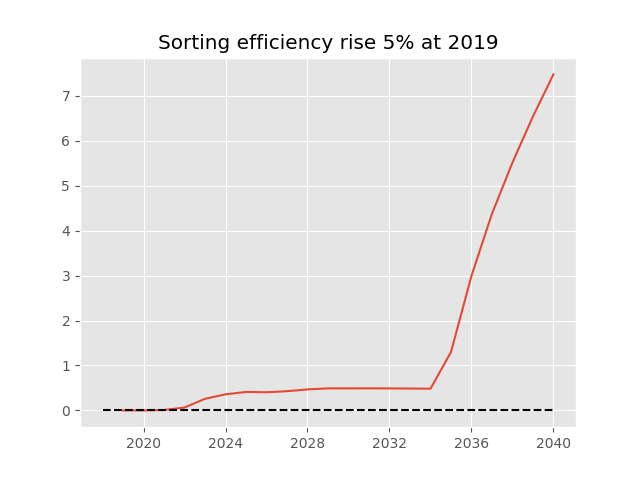

In [85]:
%matplotlib notebook
plt.plot(displacement_sc24.loc['20190101':])
plt.plot([pd.datetime(2018,1,1), pd.datetime(2040,1,1)], [0, 0], 'k--')

plt.title('Sorting efficiency rise 5% at 2019')
plt.show()